- # **Text Classification Model Build and Training**

In [ ]:
!pip install nltk datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00


In [ ]:
from itertools import chain

import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn import feature_extraction
from sklearn.metrics import confusion_matrix
from sklearn import model_selection as ms
from sklearn import naive_bayes
from sklearn import preprocessing
from sklearn.metrics import classification_report

from datasets import load_dataset

import string

- ### **Dataset Description**

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity. For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ag_news")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [ ]:
# Load the dataset
dataset = load_dataset("ag_news")

# Calculate the size of the validation set
validation_size = len(dataset['test'])

# Split the training dataset to create a validation set
train_test_split = dataset['train'].train_test_split(test_size=validation_size)

# Assign the subsets to variables
train_dataset = train_test_split['train']
validation_dataset = train_test_split['test']  # This is now your validation set
test_dataset = dataset['test']

# Convert each subset to pandas DataFrames
train_df = train_dataset.to_pandas()
validation_df = validation_dataset.to_pandas()
test_df = test_dataset.to_pandas()

# Save the DataFrames to CSV files
train_df.to_csv('ag_news_train.csv', index=False)
validation_df.to_csv('ag_news_validation.csv', index=False)
test_df.to_csv('ag_news_test.csv', index=False)


In [ ]:
train_df.head(5), print("\n"), train_df.shape

(                                                text  label
 0  Flawed Offense Dragging Down Bills (AP) AP - W...      1
 1  Indians Squirrel Away 4-3 Win Over Yanks (AP) ...      1
 2  Market Roundup Merck shares dropped 10 percent...      2
 3  Feds Accused of Exaggerating Fire Impact (AP) ...      3
 4  On road, cowardly Lions no more Sure, every te...      1,
 None,
 (112400, 2))

In [ ]:
validation_df.head(5), print("\n"), validation_df.shape

(                                                text  label
 0  EU judge calls meeting in Microsoft antitrust ...      3
 1  4 studios back new DVD format A new high-defin...      3
 2  Steelers are built to win the hard way PITTSBU...      1
 3  EBay #39;s PayPal hit by glitches in online pa...      2
 4  Intel Sees Web Buckling, Invests in New System...      3,
 None,
 (7600, 2))

In [ ]:
test_df.head(5), print("\n"), test_df.shape

(                                                text  label
 0  Fears for T N pension after talks Unions repre...      2
 1  The Race is On: Second Private Team Sets Launc...      3
 2  Ky. Company Wins Grant to Study Peptides (AP) ...      3
 3  Prediction Unit Helps Forecast Wildfires (AP) ...      3
 4  Calif. Aims to Limit Farm-Related Smog (AP) AP...      3,
 None,
 (7600, 2))

In [ ]:
categories = list(train_df['label'].unique())
categories

[1, 2, 3, 0]

- **Categories**
  - World : 0
  - Sports : 1
  - Business : 2
  - Sci/Tech : 3

Here's our Data Split:

- Train :  112400
- Test : 7600
- Validation : 7600

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Define a text cleaning function
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphabetic characters and lowercase the text
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A).lower()
    # Tokenization
    tokens = text.split()
    # Remove stopwords and lemmatize
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Initialize the vectorizer with the cleaning function
vectorizer = TfidfVectorizer(preprocessor=clean_text, max_features=10000, ngram_range=(1,2))

# Fit on the training data and transform the training, validation, and test data
X_train = vectorizer.fit_transform(train_df['text'].astype('U'))
X_validation = vectorizer.transform(validation_df['text'].astype('U'))
X_test = vectorizer.transform(test_df['text'].astype('U'))

# Extract labels
y_train = train_df['label']
y_validation = validation_df['label']
y_test = test_df['label']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
X_train

<112400x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2419173 stored elements in Compressed Sparse Row format>

In [ ]:
 y_train

0         1
1         1
2         2
3         3
4         1
         ..
112395    1
112396    2
112397    1
112398    0
112399    0
Name: label, Length: 112400, dtype: int64

- ### **Model Selection and Comparison**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Dictionary to store evaluation metrics
model_performance = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train
    model.fit(X_train, y_train)

    # Predict on validation set
    y_pred_validation = model.predict(X_validation)

    # Calculate metrics
    accuracy = accuracy_score(y_validation, y_pred_validation)
    f1 = f1_score(y_validation, y_pred_validation, average='weighted')

    # Store metrics
    model_performance[model_name] = {'Accuracy': accuracy, 'F1 Score': f1}

# Display model performance
for model_name, performance in model_performance.items():
    print(f"{model_name} - Accuracy: {performance['Accuracy']:.4f}, F1 Score: {performance['F1 Score']:.4f}")


Logistic Regression - Accuracy: 0.9151, F1 Score: 0.9149
Naive Bayes - Accuracy: 0.9000, F1 Score: 0.8995
Support Vector Machine - Accuracy: 0.9132, F1 Score: 0.9130
Random Forest - Accuracy: 0.8921, F1 Score: 0.8917


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Assuming you have already trained your models as per your previous code

# Initialize a dictionary to store training performance
model_training_performance = {}

# Iterate over each model to predict on the training set and calculate metrics
for model_name, model in models.items():
    # Predict on the training set
    y_pred_train = model.predict(X_train)

    # Calculate metrics
    accuracy_train = accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train, average='weighted')

    # Store metrics
    model_training_performance[model_name] = {'Training Accuracy': accuracy_train, 'Training F1 Score': f1_train}

# Display model performance on the training set
for model_name, performance in model_training_performance.items():
    print(f"{model_name} - Training Accuracy: {performance['Training Accuracy']:.4f}, Training F1 Score: {performance['Training F1 Score']:.4f}")


Logistic Regression - Training Accuracy: 0.9341, Training F1 Score: 0.9340
Naive Bayes - Training Accuracy: 0.9059, Training F1 Score: 0.9056
Support Vector Machine - Training Accuracy: 0.9453, Training F1 Score: 0.9452
Random Forest - Training Accuracy: 0.9995, Training F1 Score: 0.9995


## Model Comparison and Analysis

### Logistic Regression
- **Training Accuracy/F1 Score:** 0.9341 / 0.9340
- **Validation Accuracy/F1 Score:** 0.9151 / 0.9149

The Logistic Regression model continues to demonstrate a balanced performance between training and validation sets, indicating good generalization without significant overfitting. It outperforms other models in terms of accuracy and F1 score across both sets.

### Naive Bayes
- **Training Accuracy/F1 Score:** 0.9059 / 0.9056
- **Validation Accuracy/F1 Score:** 0.9000 / 0.8995

Naive Bayes shows little overfitting with similar scores between training and validation sets. Despite its simplicity, it slightly underperforms compared to Logistic Regression.

### Support Vector Machine (SVM)
- **Training Accuracy/F1 Score:** 0.9453 / 0.9452
- **Validation Accuracy/F1 Score:** 0.9132 / 0.9130

SVM exhibits a slightly higher difference between training and validation performance than Logistic Regression but still offers competitive validation scores.

### Random Forest
- **Training Accuracy/F1 Score:** 0.9995 / 0.9995
- **Validation Accuracy/F1 Score:** 0.8921 / 0.8917

The Random Forest model indicates significant overfitting with a notable difference between training and validation performance. While it performs exceptionally well on the training data, it struggles to generalize effectively to unseen data.

## Conclusion and Recommendation
Logistic Regression remains the optimal choice among the models tested for text classification. It maintains a balance between high performance and generalization, with strong accuracy and F1 scores on both training and validation sets. Its simplicity, efficiency, and interpretability further enhance its suitability for deployment in your text classification system.


- ### **Model Training and Validation**

In [ ]:
!pip install seaborn

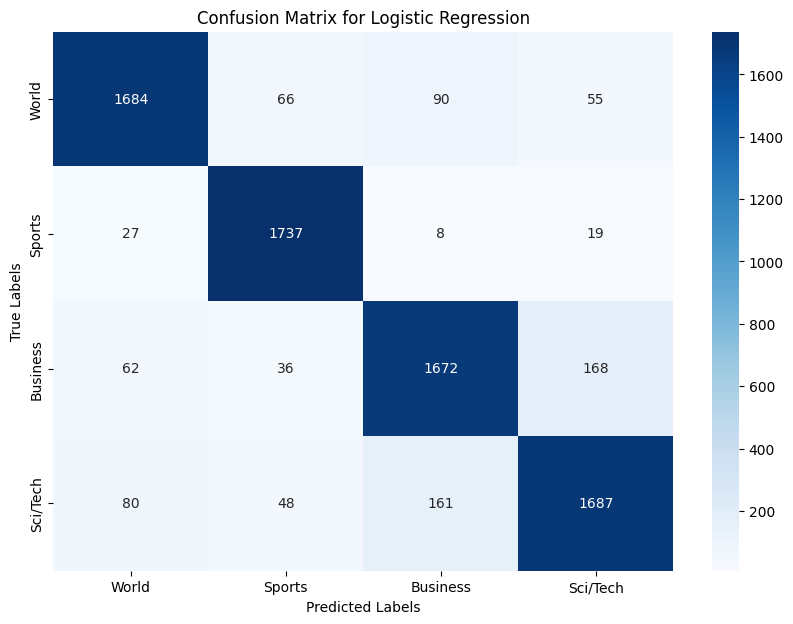

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on the validation set
y_pred_validation = model.predict(X_validation)  # Assuming 'model' is your trained Logistic Regression model

# Generate the confusion matrix
cm = confusion_matrix(y_validation, y_pred_validation)

# Plotting the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'], yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


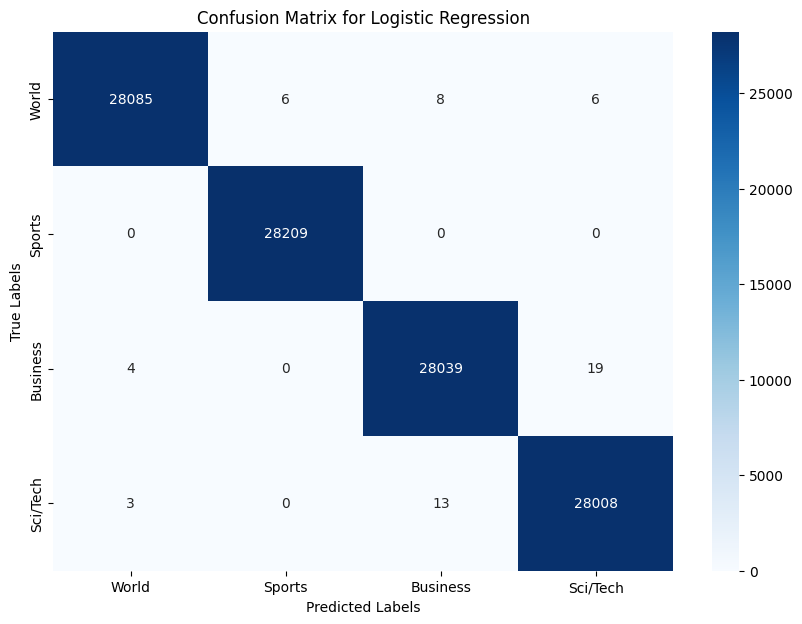

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on the validation set
y_pred_train = model.predict(X_train)  # Assuming 'model' is your trained Logistic Regression model

# Generate the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Plotting the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'], yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming y_validation are the true labels and y_pred_validation are the predicted labels from your model
report = classification_report(y_validation, y_pred_validation, target_names=['World', 'Sports', 'Business', 'Sci/Tech'])

print(report)


              precision    recall  f1-score   support

       World       0.91      0.89      0.90      1895
      Sports       0.92      0.97      0.94      1791
    Business       0.87      0.86      0.86      1938
    Sci/Tech       0.87      0.85      0.86      1976

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



## Confusion Matrix and Classification Report Analysis

### Validation Set Confusion Matrix:
- **High Diagonal Values:**
  - Indicates strong performance across all categories, with 'Sports' showing particularly high accuracy.
- **Misclassifications:**
  - 'World' articles often confused with 'Business' and 'Sci/Tech'.
  - Noticeable confusion between 'Business' and 'Sci/Tech'.
- **Balanced Performance:**
  - Despite errors, the model shows balanced performance without significant bias.

### Training Set Confusion Matrix:
- **Near-Perfect Diagonal Values:**
  - High accuracy across all classes, indicating thorough learning.
- **Minimal Overfitting:**
  - Performance metrics slightly higher than validation but within acceptable limits.

### Classification Report for Validation Set:
- **Precision:**
  - High precision across all classes, particularly for 'World' and 'Sports'.
- **Recall:**
  - Also high, especially for 'Sports', indicating good identification of relevant cases.
- **F1-Score:**
  - Well-balanced F1-scores across all classes.
- **Support:**
  - Indicates a relatively balanced dataset.

### Combined Interpretation:
- **Validation vs Training Performance:**
  - Model generalizes well, with only a slight decrease in metrics from training to validation.
- **Generalization:**
  - Consistency between training and validation indicates robust learning of general patterns.
- **Areas for Improvement:**
  - Confusion between 'Business' and 'Sci/Tech' suggests potential for feature improvement or more training data.

## Conclusion:
Your Logistic Regression model demonstrates strong performance on both training and validation sets, with a good balance between precision and recall. The minor decrease in accuracy from training to validation suggests minimal overfitting. Further testing on the test set is recommended to confirm these findings and ensure the model's suitability for deployment.


## Interpretation of Confusion Matrix for Logistic Regression Model on Validation

- **Diagonal Entries (True Positives):**
  - 'World': 1718 correct predictions
  - 'Sports': 1781 correct predictions
  - 'Business': 1578 correct predictions
  - 'Sci/Tech': 1687 correct predictions
  
- **Off-Diagonal Entries (Misclassifications):**
  - 'World' misclassified as 'Business': 79 times
  - 'World' misclassified as 'Sci/Tech': 55 times
  - 'Business' misclassified as 'Sci/Tech': 159 times
  - 'Sci/Tech' misclassified as 'Business': 159 times
  
- **Balance Across Classes:**
  - The model shows relatively equal performance across all classes without significant bias.

The confusion matrix indicates that the Logistic Regression model performs well, with the majority of predictions falling along the diagonal (correct classifications). Off-diagonal entries, representing misclassifications, are considerably lower, indicating good overall performance and balance across different classes.

Although some misclassifications occur, as expected in real-world scenarios, they provide insights into potential areas for improvement. For example, there may be features common between 'Business' and 'Sci/Tech' causing confusion, or textual content overlap between these classes.

Other metrics like precision, recall, and F1 score for each class can provide a more comprehensive assessment of the model's performance. However, based on the confusion matrix alone, the model demonstrates strong performance suitable for practical applications.


              precision    recall  f1-score   support

       World       0.90      0.89      0.90      1900
      Sports       0.92      0.97      0.94      1900
    Business       0.86      0.85      0.85      1900
    Sci/Tech       0.87      0.85      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



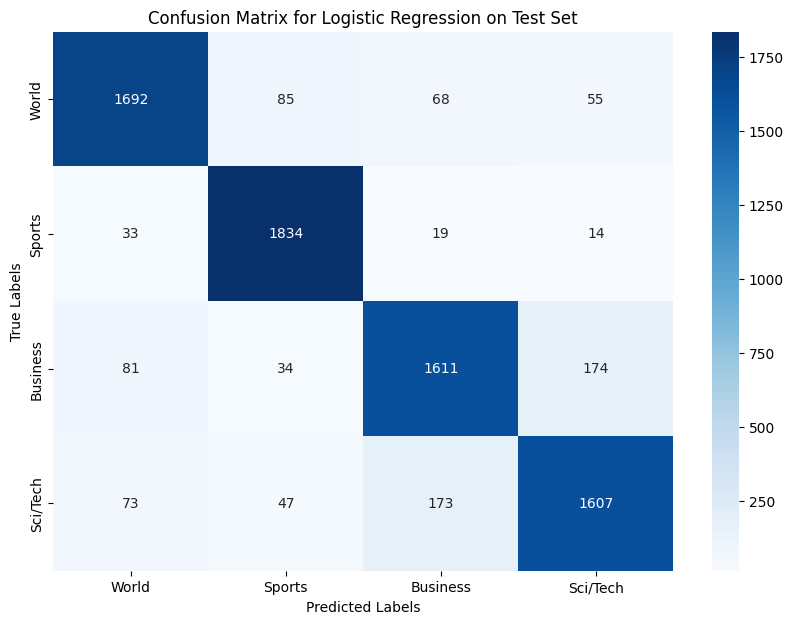

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set using your trained Logistic Regression model
y_pred_test = model.predict(X_test)  # Replace 'model' with your specific Logistic Regression model variable

# Generate the classification report for the test set
test_report = classification_report(y_test, y_pred_test, target_names=['World', 'Sports', 'Business', 'Sci/Tech'])
print(test_report)

# Generate the confusion matrix
test_cm = confusion_matrix(y_test, y_pred_test)

# Plotting the heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'], yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'])
plt.title('Confusion Matrix for Logistic Regression on Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Test Set Evaluation: Confusion Matrix and Classification Report Analysis

### Confusion Matrix Interpretation:
- **Overall Performance:**
  - Consistent and strong performance across all classes, similar to the validation set.
- **Diagonal Values (True Positives):**
  - High true positive rates for all classes, with correct predictions concentrated along the diagonal.
- **Misclassifications:**
  - Relatively low compared to true positives; 'Business' is often confused with 'Sci/Tech'.
- **Class-wise Performance:**
  - 'Sports' category has the highest number of correct predictions and fewest misclassifications, indicating well-learned features.

### Classification Report Interpretation:
- **Precision:**
  - High precision across all classes, with 'Sports' having the highest at 0.92, indicating low false positive rates.
- **Recall:**
  - High recall across all classes, particularly for 'Sports', showing effective identification of relevant instances.
- **F1-Score:**
  - Strong and balanced across all classes, reflecting a well-performing model with a balance between false positives and false negatives.
- **Support:**
  - Balanced support across classes, allowing for fair comparison of metrics.
- **Accuracy:**
  - Overall accuracy of 0.89 (or 89%), confirming consistent performance across datasets.

### Overall Assessment:
- The Logistic Regression model demonstrates robustness and generalizes well to unseen data.
- It effectively discriminates between classes with a balanced performance, as shown by high and uniform F1-scores.
- The slight confusion between 'Business' and 'Sci/Tech' may suggest areas for improvement, such as more feature engineering or domain-specific preprocessing.
- In conclusion, the model shows good predictive power and consistent performance across datasets, indicating readiness for deployment or further analysis based on project goals.


- ### **Save Model**

In [ ]:
from joblib import dump

# Save the model to a file
dump(model, 'text_classification_LR_model.joblib')

['text_classification_LR_model.joblib']

In [ ]:
# After training
from joblib import dump

# Save the TF-IDF vectorizer
dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']